In [1]:
import os
os.getcwd()
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code_mgwr")

In [2]:
import numpy as np
import geopandas as gpd

In [3]:
# now this time this pd is already have Z values
df = gpd.read_file('data/cleaned/grid_data_for_weights_mgwr03.geojson')

In [4]:
df.columns

Index(['grid_id', 'row', 'col', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'Id', 'Ward_No', 'POP', 'beta_intercept', 'beta_illum_vol',
       'beta_light_intensity', 'beta_poi_kde', 'poi_kde_scaled',
       'illum_vol_density_std', 'light_intensity_std', 'poi_kde_scaled_std',
       'Predicted_Z_Y', 'Predicted_log_Y', 'geometry'],
      dtype='object')

In [5]:
# # Recalculate raw linear predictor Z
# grid_with_wards['Z'] = (
#         grid_with_wards['intercept']
#         + grid_with_wards['illum_vol_estimate'] * grid_with_wards['illum_vol']
#         + grid_with_wards['light_intensity_estimate'] * grid_with_wards['light_intensity']
#         + grid_with_wards['poi_kde_estimate'] * grid_with_wards['poi_kde']
# )
# print(f"Z value range: {grid_with_wards['Z'].min():.2f} to {grid_with_wards['Z'].max():.2f}")
# negative_count = (grid_with_wards['Z'] < 0).sum()
# print(f"Negative Z values: {negative_count} ({negative_count / len(grid_with_wards) * 100:.1f}%)")


In [6]:
print("\n--- Step 2: Defining parameters and identifying areas ---")

# Parameters for weighting
GAMMA = 0.5  # Softmax sharpness: >1 sharper, <1 smoother
ALPHA = 0.5  # Power transform for smoothing: <1 compresses high values
BASE_WEIGHT_UNINHABITED = 1e-9 # A very small base weight for non-residential areas for visulization, but does not contribute to population as the remainder fucntion will not allocate any population to these areas.
WINSOR_THRESHOLD = 0.99 # Percentile to cap extreme weights


--- Step 2: Defining parameters and identifying areas ---


In [7]:
# Define inhabited vs. uninhabited areas based on a key variable
# Using 'illum_vol_density' is a robust choice.
uninhabited_mask = (df['illum_vol_density'] == 0)
habited_mask = ~uninhabited_mask

print(f"Gamma={GAMMA}, Alpha={ALPHA}, Winsor Threshold={WINSOR_THRESHOLD*100}%")
print(f"Identified {uninhabited_mask.sum()} uninhabited grids out of {len(df)} total.")

Gamma=0.5, Alpha=0.5, Winsor Threshold=99.0%
Identified 24898 uninhabited grids out of 38906 total.


# Standardize the Z

In [8]:
# Introduce a smoothing parameter epsilon in the Softmax function
# --- 3. Calculate Preliminary Weights (w_pt) ---
print("\n--- Step 3: Calculating preliminary weights (w_pt) ---")

def softmax_on_scaled_z(z_vals, gamma=1.0):
    """Calculates softmax on min-max scaled values."""
    # ensure working with a NumPy array
    z = np.asarray(z_vals, dtype=float)
    # if all are nan, return an array of nans
    if np.isnan(z).all():
        return np.full_like(z, np.nan)
    # compute min and max ignoring nan
    z_min = np.nanmin(z)
    z_max = np.nanmax(z)
    # if constant, return uniform weights
    if z_max == z_min:
        return np.full_like(z, 1.0 / z.size)
    # min–max scale
    z_scaled = (z - z_min) / (z_max - z_min)
    exps = np.exp(gamma * z_scaled)
    return exps / np.nansum(exps)

# a. Calculate softmax weights for HABITED areas
df['w_raw'] = np.nan
df.loc[habited_mask, 'w_raw'] = df[habited_mask].groupby('Id')['Predicted_log_Y'].transform(
    lambda z: softmax_on_scaled_z(z.values, gamma=GAMMA)
)

# b. Apply alpha power transform to smooth the raw weights
df['w_pt'] = np.nan
df.loc[habited_mask, 'w_pt'] = df.loc[habited_mask, 'w_raw'] ** ALPHA

# c. Assign a tiny base weight to UNINHABITED areas
df.loc[uninhabited_mask, 'w_pt'] = BASE_WEIGHT_UNINHABITED



--- Step 3: Calculating preliminary weights (w_pt) ---


In [9]:
# --- 4. Normalize, Winsorize, and Finalize Weights ---
print("\n--- Step 4: Normalizing, winsorizing, and finalizing weights ---")

# a. First normalization to get initial final weights
df['w_initial'] = df.groupby('Id')['w_pt'].transform(lambda w: w / w.sum())

# b. Winsorize (trim) the weights to handle outliers
threshold = df['w_initial'].quantile(WINSOR_THRESHOLD)
df['w_trim'] = np.minimum(df['w_initial'], threshold)

# c. Final re-normalization to get the final weights for disaggregation
df['w_final_trim'] = df.groupby('Id')['w_trim'].transform(lambda w: w / w.sum())


--- Step 4: Normalizing, winsorizing, and finalizing weights ---


In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
#
#
# weights = df['w_final']
#
#
# plt.figure(figsize=(10, 6))
# plt.hist(weights, bins=100)
# plt.title('Histogram of Final Weights (w_final)')
# plt.xlabel('Weight Value')
# plt.ylabel('Frequency')
# plt.show()
#
# # calculate key percentiles
# qs = [0.90, 0.95, 0.99, 0.995, 1.0]
# percentiles = weights.quantile(qs)
# print("Key percentiles of w_final:")
# print(percentiles)


In [11]:
# import numpy as np
# import matplotlib.pyplot as plt
#
# # 1. take 99% as threshold
# threshold = df.loc[habited_mask, 'w_final'].quantile(0.99)
#
# # 2. Winsorize：cut off weights above the threshold
# df.loc[habited_mask, 'w_trim'] = np.minimum(df.loc[habited_mask, 'w_final'], threshold)
#
# # 3. normalize the trimmed weights per ward
# df.loc[habited_mask, 'w_final_trim'] = (
#    df[habited_mask]
#       .groupby('Id')['w_trim']
#       .transform(lambda w: w / w.sum())
# )

In [12]:
# # View statistics of w_final
# stats = df['w_final_trim'].describe()
# print(stats)

In [13]:
print("\n--- Step 5: Disaggregating population to floating point values ---")
df['population_final_trim'] = (
df['w_final_trim'] * df['POP']
)


--- Step 5: Disaggregating population to floating point values ---


In [14]:
# View statistics of population_final_trim
stats = df['population_final_trim'].describe()
print(stats)

count    3.890600e+04
mean     7.849453e+01
std      1.510366e+02
min      5.315409e-07
25%      1.180949e-06
50%      1.756682e-06
75%      1.146190e+02
max      1.718667e+03
Name: population_final_trim, dtype: float64


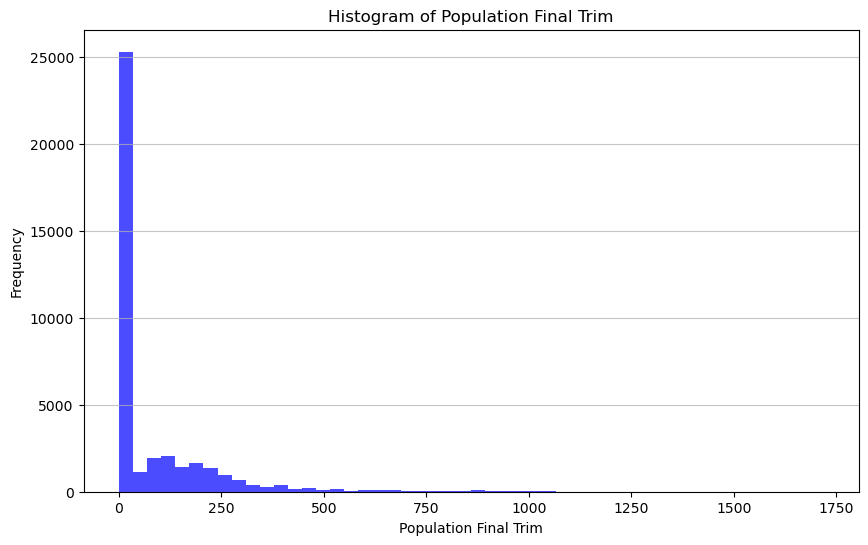

In [15]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'population_final_trim' is the column of interest
plt.figure(figsize=(10, 6))
plt.hist(df['population_final_trim'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Population Final Trim')
plt.xlabel('Population Final Trim')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

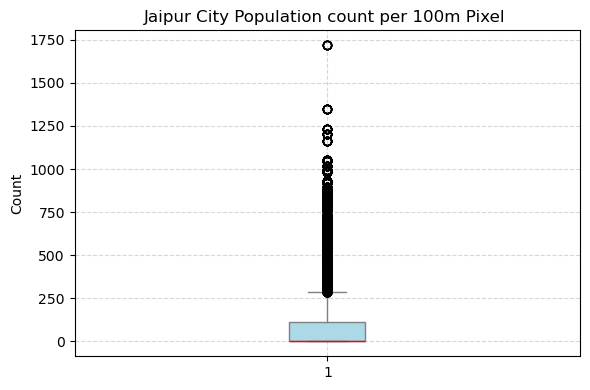

In [16]:
plt.figure(figsize=(6,4))
plt.boxplot(df['population_final_trim'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='gray'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'))
plt.ylabel("Count")
plt.title("Jaipur City Population count per 100m Pixel ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()


In [17]:
df.columns

Index(['grid_id', 'row', 'col', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'Id', 'Ward_No', 'POP', 'beta_intercept', 'beta_illum_vol',
       'beta_light_intensity', 'beta_poi_kde', 'poi_kde_scaled',
       'illum_vol_density_std', 'light_intensity_std', 'poi_kde_scaled_std',
       'Predicted_Z_Y', 'Predicted_log_Y', 'geometry', 'w_raw', 'w_pt',
       'w_initial', 'w_trim', 'w_final_trim', 'population_final_trim'],
      dtype='object')

In [18]:
df.head(20
        )

,grid_id,row,col,illum_vol_density,light_intensity,poi_kde,Id,Ward_No,POP,beta_intercept,...,poi_kde_scaled_std,Predicted_Z_Y,Predicted_log_Y,geometry,w_raw,w_pt,w_initial,w_trim,w_final_trim,population_final_trim
0,57,0,57,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574070 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
1,58,0,58,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574170 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
2,59,0,59,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574270 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
3,60,0,60,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574370 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
4,61,0,61,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574470 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
5,62,0,62,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574570 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
6,63,0,63,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574670 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
7,64,0,64,0.0,0.0,0.000000e+00,1.0,1.0,11930.0,0.0,...,-2.402737,261.538789,272.81624,POINT (574770 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
8,65,0,65,0.0,0.0,1.173807e-10,1.0,1.0,11930.0,0.0,...,-2.218997,261.538789,272.81624,POINT (574870 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002
9,66,0,66,0.0,0.0,1.217358e-10,1.0,1.0,11930.0,0.0,...,-2.212557,261.538789,272.81624,POINT (574970 2989540),NaN,1.000000e-09,1.274606e-10,1.274606e-10,1.274606e-10,0.000002


In [19]:
print("\n--- Step 6: Converting to integer population with exact conservation ---")

# 1. Take floor of population_final_trim to get base integer allocation
df['pop_floor'] = np.floor(df['population_final_trim']).astype(int)

# 2. Calculate remainder for each grid (fractional part)
df['remainder'] = df['population_final_trim'] - df['pop_floor']

# 3. Improved distribution function using Largest Remainder Method
def distribute_integer_population(group):
    """
    Distribute population to integer values ensuring exact ward-level conservation.
    Uses Largest Remainder Method (Hamilton's method) for fair allocation.
    """
    group = group.copy()

    # Get the target total population for this ward (must be integer)
    ward_pop_target = int(group['POP'].iloc[0])

    # Start with floor values
    group['pop_int_temp'] = group['pop_floor'].copy()
    current_total = group['pop_int_temp'].sum()

    # Calculate how many additional people need to be distributed
    remaining_population = ward_pop_target - current_total

    if remaining_population > 0:
        # Need to add population: select grids with highest remainders
        if remaining_population > len(group):
            print(f"Warning: Ward {group['Id'].iloc[0]} needs to distribute {remaining_population} people among {len(group)} grids")
            # Distribute as evenly as possible
            base_addition = remaining_population // len(group)
            extra_addition = remaining_population % len(group)

            # Add base amount to all grids
            group['pop_int_temp'] += base_addition

            # Add extra to grids with highest remainders
            if extra_addition > 0:
                top_remainder_idx = group.nlargest(extra_addition, 'remainder').index
                group.loc[top_remainder_idx, 'pop_int_temp'] += 1
        else:
            # Normal case: add 1 person to grids with highest remainders
            top_remainder_idx = group.nlargest(remaining_population, 'remainder').index
            group.loc[top_remainder_idx, 'pop_int_temp'] += 1

    elif remaining_population < 0:
        # Need to remove population: select grids with lowest remainders
        people_to_remove = abs(remaining_population)

        if people_to_remove > len(group):
            print(f"Warning: Ward {group['Id'].iloc[0]} needs to remove {people_to_remove} people from {len(group)} grids")
            # Remove as evenly as possible, but ensure no negative values
            for _ in range(people_to_remove):
                # Find grid with lowest remainder that still has population > 0
                candidates = group[group['pop_int_temp'] > 0]
                if len(candidates) == 0:
                    print(f"Error: Cannot remove more people from ward {group['Id'].iloc[0]}")
                    break
                lowest_remainder_idx = candidates['remainder'].idxmin()
                group.loc[lowest_remainder_idx, 'pop_int_temp'] -= 1
        else:
            # Normal case: remove 1 person from grids with lowest remainders
            # But ensure we don't create negative populations
            for _ in range(people_to_remove):
                candidates = group[group['pop_int_temp'] > 0]
                if len(candidates) == 0:
                    break
                lowest_remainder_idx = candidates['remainder'].idxmin()
                group.loc[lowest_remainder_idx, 'pop_int_temp'] -= 1

    # Ensure all values are non-negative integers
    group['pop_int_temp'] = np.maximum(0, group['pop_int_temp']).astype(int)

    return group

# Apply the integer distribution function
print("Applying Largest Remainder Method for integer allocation...")
df = df.groupby('Id', group_keys=False).apply(distribute_integer_population)

# Set the final integer population column
df['pop_int'] = df['pop_int_temp'].astype(int)

# Clean up temporary column
df = df.drop('pop_int_temp', axis=1)


--- Step 6: Converting to integer population with exact conservation ---
Applying Largest Remainder Method for integer allocation...


C:\Users\Aprilmiaoyilee\AppData\Local\Temp\ipykernel_23024\3582844215.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Id', group_keys=False).apply(distribute_integer_population)


In [20]:
print("\n--- Step 7: Comprehensive validation of integer population conservation ---")

# Create comprehensive validation summary
validation_summary = df.groupby('Id').agg({
    'POP': 'first',  # Original ward population (integer)
    'pop_int': 'sum',  # Sum of allocated integer population
    'population_final_trim': 'sum'  # Sum of float population (should equal POP)
}).round(6)

# Calculate differences
validation_summary['int_diff'] = validation_summary['pop_int'] - validation_summary['POP']
validation_summary['float_diff'] = validation_summary['population_final_trim'] - validation_summary['POP']

# Identify conservation errors
int_errors = validation_summary[validation_summary['int_diff'] != 0]
float_errors = validation_summary[validation_summary['float_diff'].abs() > 1e-6]

print(f"=== VALIDATION RESULTS ===")
print(f"Total wards processed: {len(validation_summary)}")
print(f"Wards with PERFECT integer conservation: {len(validation_summary) - len(int_errors)}")
print(f"Wards with PERFECT float conservation: {len(validation_summary) - len(float_errors)}")

# Report integer conservation status
if len(int_errors) == 0:
    print("\n✅ SUCCESS: ALL wards have exact integer population conservation!")
    print("   Every ward's sum(pop_int) equals original POP value")
else:
    print(f"\n❌ ERROR: {len(int_errors)} wards have integer conservation errors!")
    print("Problematic wards:")
    error_display = int_errors[['POP', 'pop_int', 'int_diff']].copy()
    error_display.columns = ['Original_POP', 'Allocated_Sum', 'Difference']
    print(error_display)

    # Detailed analysis of errors
    max_error = int_errors['int_diff'].abs().max()
    print(f"Maximum absolute error: {max_error}")
    print(f"Total population error: {int_errors['int_diff'].sum()}")

# Report float conservation status (should be perfect due to weight normalization)
if len(float_errors) > 0:
    print(f"\n⚠️  WARNING: {len(float_errors)} wards have float conservation errors!")
    print("This indicates weight normalization issues:")
    print(float_errors[['POP', 'population_final_trim', 'float_diff']].head())

# Global conservation check
total_original = df.groupby('Id')['POP'].first().sum()  # Sum original ward populations
total_allocated = df['pop_int'].sum()  # Sum all allocated populations

print(f"\n=== GLOBAL CONSERVATION CHECK ===")
print(f"Total original population: {total_original:,}")
print(f"Total allocated population: {total_allocated:,}")
print(f"Global difference: {total_allocated - total_original:,}")

if total_allocated == total_original:
    print("✅ PERFECT global population conservation achieved!")
else:
    print("❌ Global population conservation error detected!")

# Verify all pop_int values are integers
non_integer_grids = df[df['pop_int'] != df['pop_int'].astype(int)]
if len(non_integer_grids) == 0:
    print("✅ All grid populations are integers")
else:
    print(f"❌ {len(non_integer_grids)} grids have non-integer populations!")

# Check for negative populations
negative_pop_grids = df[df['pop_int'] < 0]
if len(negative_pop_grids) == 0:
    print("✅ No negative population values")
else:
    print(f"❌ {len(negative_pop_grids)} grids have negative populations!")

print(f"\n=== FINAL STATISTICS ===")
print(f"Total grids: {len(df):,}")
print(f"Grids with population > 0: {(df['pop_int'] > 0).sum():,}")
print(f"Grids with population = 0: {(df['pop_int'] == 0).sum():,}")
print(f"Maximum grid population: {df['pop_int'].max()}")
print(f"Mean grid population: {df['pop_int'].mean():.2f}")

# Additional validation: Detailed per-ward summary for verification
print("\n--- Detailed per-ward verification (showing first 10 wards) ---")
detailed_check = df.groupby('Id').agg({
    'POP': 'first',
    'pop_int': ['sum', 'count', 'max', 'min']
}).round(0)

# Flatten column names
detailed_check.columns = ['Original_POP', 'Allocated_Sum', 'Grid_Count', 'Max_Grid_Pop', 'Min_Grid_Pop']
detailed_check['Perfect_Match'] = (detailed_check['Original_POP'] == detailed_check['Allocated_Sum'])

print("Sample ward verification:")
print(detailed_check.head(10))
print(f"\nWards with perfect allocation: {detailed_check['Perfect_Match'].sum()}/{len(detailed_check)}")

# Weight normalization verification
print("\n--- Weight normalization verification ---")
weight_sums = df.groupby('Id')['w_final_trim'].sum()
perfect_weights = (np.abs(weight_sums - 1.0) < 1e-10).sum()
print(f"Wards with perfect weight normalization (sum = 1.0): {perfect_weights}/{len(weight_sums)}")

if perfect_weights != len(weight_sums):
    weight_errors = weight_sums[np.abs(weight_sums - 1.0) >= 1e-10]
    print(f"Weight normalization errors found in {len(weight_errors)} wards:")
    print(weight_errors.head())


--- Step 7: Comprehensive validation of integer population conservation ---
=== VALIDATION RESULTS ===
Total wards processed: 251
Wards with PERFECT integer conservation: 251
Wards with PERFECT float conservation: 251

✅ SUCCESS: ALL wards have exact integer population conservation!
   Every ward's sum(pop_int) equals original POP value

=== GLOBAL CONSERVATION CHECK ===
Total original population: 3,053,908.0
Total allocated population: 3,053,908
Global difference: 0.0
✅ PERFECT global population conservation achieved!
✅ All grid populations are integers
✅ No negative population values

=== FINAL STATISTICS ===
Total grids: 38,906
Grids with population > 0: 14,008
Grids with population = 0: 24,898
Maximum grid population: 1719
Mean grid population: 78.49

--- Detailed per-ward verification (showing first 10 wards) ---
Sample ward verification:
      Original_POP  Allocated_Sum  Grid_Count  Max_Grid_Pop  Min_Grid_Pop  \
Id                                                                

In [23]:
df.to_file('data/cleaned/grid_pop_mgwr04.geojson', driver='GeoJSON')

In [24]:
df.describe()

,grid_id,row,col,illum_vol_density,light_intensity,poi_kde,Id,Ward_No,POP,beta_intercept,...,Predicted_log_Y,w_raw,w_pt,w_initial,w_trim,w_final_trim,population_final_trim,pop_floor,remainder,pop_int
count,38906.000000,38906.000000,38906.000000,38906.000000,38906.000000,3.890600e+04,38906.000000,38906.000000,38906.000000,38906.000000,...,38906.000000,14008.000000,3.890600e+04,3.890600e+04,3.890600e+04,3.890600e+04,3.890600e+04,38906.000000,3.890600e+04,38906.000000
mean,31943.337017,142.738035,112.755153,505.297046,10.919580,1.323916e-09,110.411505,69.475993,11875.855806,0.680088,...,208.887488,0.017918,4.531750e-02,6.451447e-03,6.306491e-03,6.451447e-03,7.849453e+01,78.314270,1.802550e-01,78.494525
std,14652.062173,65.660875,52.523519,770.638587,15.712047,2.461920e-09,65.739897,44.202550,1534.745512,1.928375,...,78.063204,0.014204,6.631654e-02,1.198793e-02,1.113143e-02,1.197395e-02,1.510366e+02,150.867805,2.972658e-01,151.036831
min,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,8491.000000,-3.712855,...,62.397654,0.001678,1.000000e-09,4.992870e-11,4.992870e-11,4.992870e-11,5.315409e-07,0.000000,5.315409e-07,0.000000
25%,20564.250000,92.000000,71.000000,0.000000,0.000000,0.000000e+00,56.000000,33.000000,10646.000000,0.000000,...,119.080345,0.008955,1.000000e-09,9.955497e-11,9.955497e-11,9.955497e-11,1.180949e-06,0.000000,1.180949e-06,0.000000
50%,32229.500000,144.000000,110.000000,0.000000,0.000000,0.000000e+00,113.000000,71.000000,12023.000000,0.000000,...,222.129248,0.014495,1.000000e-09,1.447541e-10,1.447541e-10,1.447541e-10,1.756682e-06,0.000000,1.756682e-06,0.000000
75%,43026.750000,192.000000,157.000000,1050.000000,26.151287,1.737897e-09,151.750000,110.000000,12716.000000,0.000000,...,277.391984,0.022423,9.944614e-02,9.952245e-03,9.952245e-03,9.952245e-03,1.146190e+02,114.000000,2.977765e-01,115.000000
max,62580.000000,280.000000,221.000000,3477.942600,74.912239,1.328428e-08,251.000000,150.000000,16541.000000,6.094717,...,329.550635,0.214366,4.629970e-01,1.896631e-01,5.740579e-02,1.666667e-01,1.718667e+03,1718.000000,9.998715e-01,1719.000000
